## E-Learning 5b - Neutral Networks (Solution)
Automatic recognition of handwritten digits is an important problem which can be found in many practical applications. In this exercise, we shall use the MNIST database of handwritten digits.The MNIST dataset is made up of a training set of 60,000 examples (in file `mnist_train.csv.gz`), plus a test set of 10000 examples (in file `mnist_test.csv`). Both files are located in the `data` directory. The source images were originally in black and white but later, to normalize them to the size of 20 × 20 pixels, intermediate brightness levels were introduced due to the effect of the anti-aliasing filter for resizing. Subsequently, the images were focused in the center of mass of the pixels, in an area of 28×28 pixels, in order to improve the learning process.

### Loading the Data
The first element of each row in the data file is the label (a number from 0 to 9) which represents the numerical value of the handwritten digit of the image. The rest of the 784 values are pixel values of the 28x28 handwritten digit image. We shall name the column for the first pixel value `pixel0`, the second pixel value `pixel1` and so on. We shall generate the column names computationally, create the schema and load the data into a DataFrame:

```python
from pyspark.sql.types import *

pixel_labels = [ 'pixel' + str(i) for i in range(784) ]
data_labels = ['label'] + pixel_labels
schema = StructType( [StructField(e, DoubleType(), True) for e in data_labels] )

train_df = spark.read.csv("/home/training/data/mnist_train.csv.gz", schema=schema)
test_df = spark.read.csv("/home/training/data/mnist_test.csv", schema=schema)
```

In [1]:
from pyspark.sql.types import *

pixel_labels = [ 'pixel' + str(i) for i in range(784) ]
data_labels = ['label'] + pixel_labels
schema = StructType( [StructField(e, DoubleType(), True) for e in data_labels] )

train_df = spark.read.csv("/home/training/data/mnist_train.csv.gz", schema=schema)
test_df = spark.read.csv("/home/training/data/mnist_test.csv", schema=schema)

Let us see the image of the first record from the training data. The code is as follows:
```python
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# take the first record and extract the pixel values into an array
row = train_df.first()
pixels = np.array(row[1:], dtype='uint8')

# reshape the array into a 28 x 28 array (2-dimensional array)
pixels = pixels.reshape((28, 28))

# display the image
plt.title('Label is {label}'.format(label=row[0]))
plt.imshow(pixels, cmap='gray')
plt.show()
```

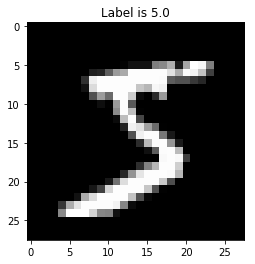

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# take the first record and extract the pixel values into an array
row = train_df.first()
pixels = np.array(row[1:], dtype='uint8')

# reshape the array into a 28 x 28 array (2-dimensional array)
pixels = pixels.reshape((28, 28))

# display the image
plt.title('Label is {label}'.format(label=row[0]))
plt.imshow(pixels, cmap='gray')
plt.show()

### Creating transformers
We shall use the `VectorAssembler` to assemble the values from all the pixel columns into an output column:
```python
import pyspark.ml.feature as ft
featuresCreator = ft.VectorAssembler(inputCols=pixel_labels, outputCol='features')
```

In [3]:
import pyspark.ml.feature as ft
featuresCreator = ft.VectorAssembler(inputCols=pixel_labels, outputCol='features')

### Creating an Estimator
Next, we create our multi-layer perceptron estimator. 
```python
import pyspark.ml.classification as cl
mlpc = cl.MultilayerPerceptronClassifier(layers=[784,50,25,10], seed=666)
```
Our neural network will contain two hidden layers of size 50 and 25. Having more hidden layers will make the model creation more time consuming but more accurate. Likewise for increasing the size of the hidden layers. Even with this configuration, the model creation will take about 5 to 10 minutes to complete (so please be very patient).

In [4]:
import pyspark.ml.classification as cl
mlpc = cl.MultilayerPerceptronClassifier(layers=[784,50,25,10], seed=666)

### Creating a Pipeline
Now, create a Pipeline to pull the different transformations together:
```python
from pyspark.ml import Pipeline
pipeline = Pipeline( stages = [featuresCreator, mlpc] )
```

In [5]:
from pyspark.ml import Pipeline
pipeline = Pipeline( stages = [featuresCreator, mlpc] )

### Fitting the Model
Now, run our pipeline to estimate our model:
```python
train_df.persist()
model = pipeline.fit(train_df)
test_model = model.transform(test_df)
```

In [6]:
train_df.persist()
model = pipeline.fit(train_df)
test_model = model.transform(test_df)

### Evaluating the Performance of the Model
To evaluate the performance of our model, we can use the `MulticlassClassificationEvaluator` class and its `evaluate` method:
```python
import pyspark.ml.evaluation as ev
evaluator = ev.MulticlassClassificationEvaluator()
print(evaluator.evaluate(test_model, {evaluator.metricName: 'accuracy'}))
```

In [7]:
import pyspark.ml.evaluation as ev
evaluator = ev.MulticlassClassificationEvaluator()
print(evaluator.evaluate(test_model, {evaluator.metricName: 'accuracy'}))

0.9182
